### Try Different Kernel Functions

In [1]:
import random
import os, gc, itertools
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None
from astropy.table import Table, vstack

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

import GP_Kernels_Classes

unique_wavelengths:  [3685. 4802. 6231. 7542. 8690. 9736.] (6,)


We are using codes from [here](https://github.com/tallamjr/astronet/blob/master/notebooks/GP-Interpolation-Transient-Only-PLAsTiCC.ipynb) to treat every time series with same interval; 

But Instead of George, We build the pipeline using Sklearn for further convenience

In [2]:
gc.collect()
#read csv
training = pd.read_csv('../Train-Data/training_set.csv')

meta_training = pd.read_csv('../Train-Data/training_set_metadata.csv')

print ('check shapes: ', training.shape, meta_training.shape)
print ('\n')
print (training.head(5))

meta_training.head(5)

check shapes:  (1421705, 6) (7848, 12)


   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [3]:
my_map = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}
training['passband_n'] = training['passband'].map(my_map)
training.head(3)

,object_id,mjd,passband,flux,flux_err,detected,passband_n
0,615,59750.4229,2,-544.810303,3.622952,1,r
1,615,59750.4306,1,-816.434326,5.553370,1,g
2,615,59750.4383,3,-471.385529,3.801213,1,i


--------------------------------------------------------



### Try GP to Fill Up Time Series Flux Values

For this particular task, choice of kernel is an important parameter. 

We can try 2 of them: RBF and Matérn

1. **RBF Kernel (Parametrized by Length Scale: $l$)**:

    $$k(x_i, \, x_j) = \text{exp}\, \left(\frac{d(x_i,\, x_j)^2}{2l^2}\right); \, $$

    $d(x_i,\, x_j)$ is the Euclidean distance and $l>0$ is the length parameter which can either be scaler or a vector with same input
    dimension as $x$. 

    This kernel is infinitely differentiable, which implies that GPs with this kernel as covariance function have mean square derivatives of
    all orders, and are thus very smooth.


2. **Matérn Kernel (Smoothness Parameter: $\nu$)**: 

    $$k(x_i,\, x_j) = \frac{1}{2\Gamma (\nu)\, 2^{\nu -1}}\, \left(\frac{\sqrt{2\nu}}{l} \, d(x_i, \, x_j)\right)^{\nu}\, K_{\nu}\left(\frac{\sqrt{2\nu}}{l} \, d\left(x_i, \, x_j\right)\right)$$

    Here $\Gamma (\cdot)$ is the Gamma Function and $K_{\nu}(\cdot)$ is a modified Bessel Function. 
    There are few variations of Matérn Kernel that needs discussing. 
    
    **$\nu = \frac{1}{2} \rightarrow$ (Leads to Exponential Kernel)**
    $$k(x_i,\, x_j) = \text{exp}\left(-\frac{1}{l} \, d(x_i, x_j)\right)$$
    
    **$\nu = \frac{3}{2} \rightarrow$ (Differentiable At-Least Once)**
    $$k(x_i,\, x_j) = \left(1 + \frac{\sqrt{3}}{l}\, d(x_i, \, x_j)\right)\, \text{exp}\left(-\frac{\sqrt{3}}{l}\, d(x_i, \, x_j)\right)$$
    
    **$\nu = \frac{5}{2} \rightarrow$ (Differentiable At-Least Twice)**
    $$k(x_i,\, x_j) = \left(1 + \frac{\sqrt{5}}{l}\, d(x_i, \, x_j) + \frac{5}{3l}\, d(x_i, \, x_j)^2\right)\, \text{exp}\left(-\frac{\sqrt{5}}{l}\, d(x_i, \, x_j)\right)$$
    
    **$\nu \rightarrow \infty$ (Leads to RBF Kernel)**
    
    The popular choices for $\nu$ are $\frac{3}{2}, \, \frac{5}{2}$. Specifically in the paper _[Paying Attention to the Astronomical Transients](https://arxiv.org/abs/2105.06178)_ dealing with irregualr time series for PLAsTiCC data challenge, the authors have used Matérn Kernel with smoothness parameter set to $\frac{3}{2}$ for GP regression task.    
    
    
    
3. **Rational Quadratic Kernel**:

    $$k(x_i, \, x_j) = \left(1 + \frac{d(x_i, x_j)^2}{2\alpha l^2}\right)^{-\alpha}$$
    
    Here $l$ is the length scale parameter and $\alpha > 0$ is the scale mixture parameter. 


In [4]:
object_list = list(np.unique(training['object_id']))
print (len(object_list))

#object_list_sel = random.sample(object_list, 4)
#print ('check selected objects: ', object_list_sel)

7848


In [5]:
###############################
# info for plots and others
###############################

colors_6_dict = {'u':'violet', 'g':'green', 'r':'red', 'i':'indigo', 'z':'darkslategray', 'y':'yellow'}
marker_list = ['o', 'p', 's', 'd', '*', '^']
unique_passband = np.unique(training['passband_n'])
colors_6_list = ['violet', 'green', 'red', 'indigo', 'darkslategray', 'yellow']
pb_wavelengths = {"u": 3685., "g": 4802., "r": 6231.,
                  "i": 7542., "z": 8690., "y": 9736.}
inverse_pb_wavelengths = {v: k for k, v in pb_wavelengths.items()}

gp_wavelengths = np.vectorize(pb_wavelengths.get)(unique_passband)

unique_wavelengths = np.unique(gp_wavelengths)

Using Mater32 Kernel
Using Mater32 Kernel


/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


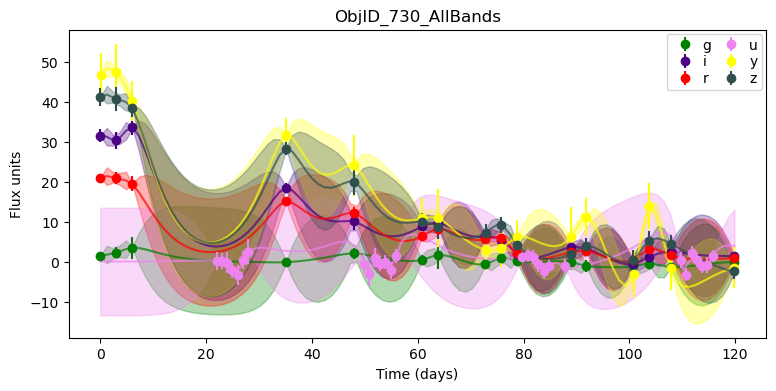

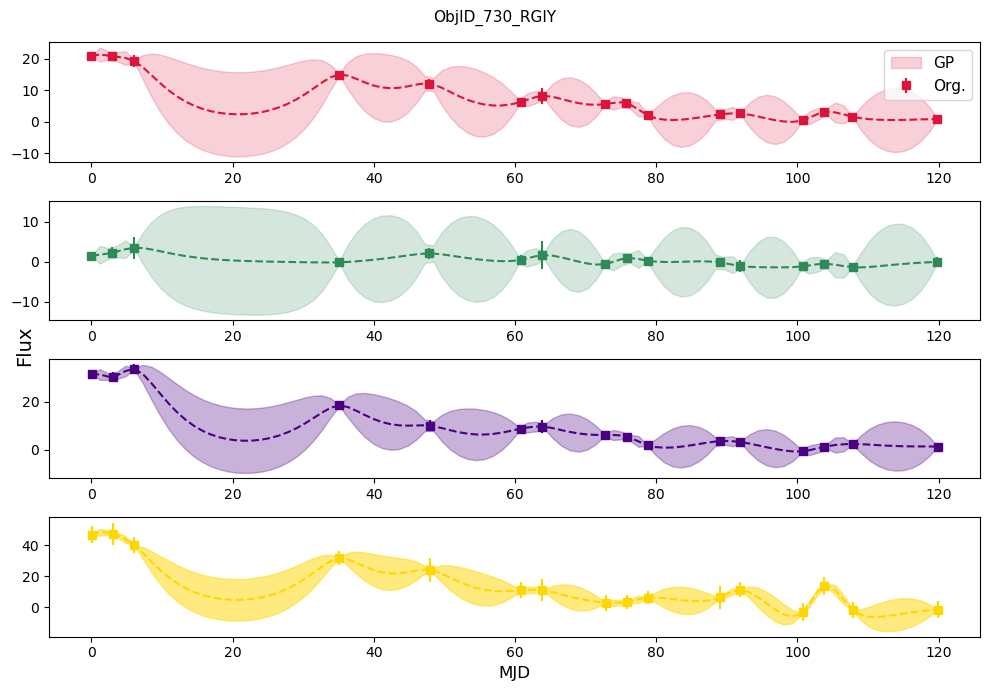

In [9]:
################################
# check for a particular object ID
################################

obj_id = object_list[2]

GP_class_init = GP_Kernels_Classes.GP_for_transient(input_df=training, obj_id=obj_id)

obs_transient = GP_class_init.shift_time()

x_dates_dict, y_dict, y_err_dict = GP_Kernels_Classes.return_flux_w_err(obs_transient)

obj_gps = GP_class_init.gp_fit_predict()
obj_gps = GP_class_init.pred_gp_fl_final()




x_dates_dict_gp, y_dict_gp, y_err_dict_gp = GP_Kernels_Classes.return_flux_w_err(obj_gps)

##################################
# final plot for original and GP
##################################
GP_Kernels_Classes.plot_real_data_and_model(obs_transient, obj_id, obj_model=obj_gps)

GP_Kernels_Classes.plot_4_bands_w_GP(x_dates_dict, x_dates_dict_gp, y_dict, y_dict_gp, 
                                     y_err_dict, y_err_dict_gp, obj_id)

### Try For a Same Object (RBF Kernel)

using Quadratic Kernel
using Quadratic Kernel


/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


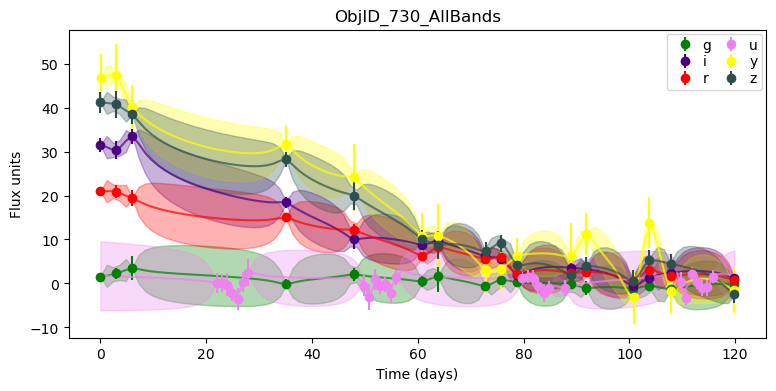

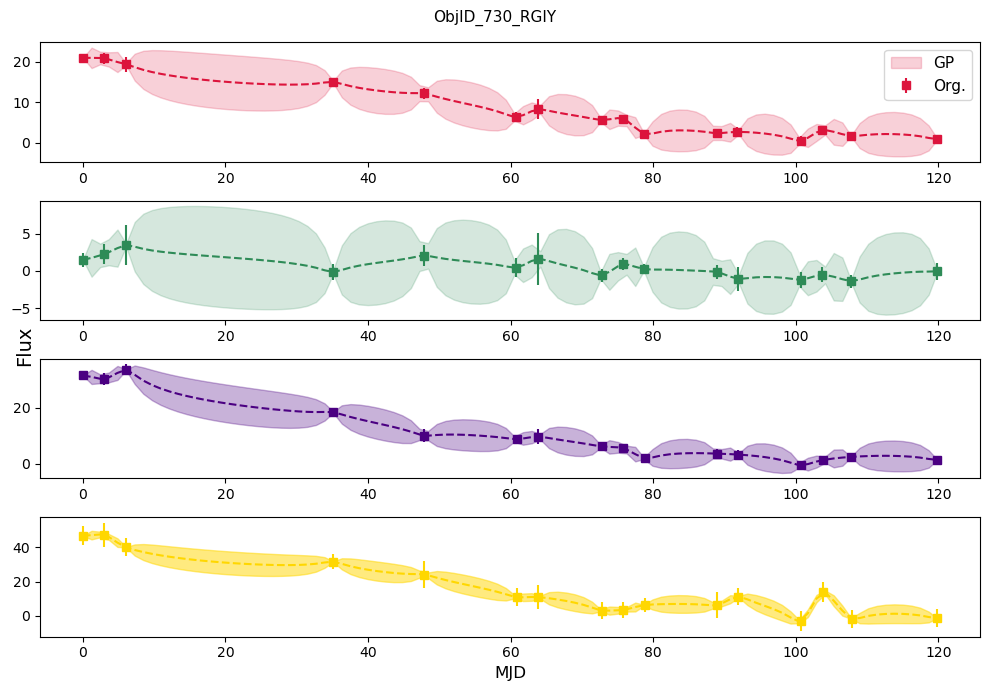

In [10]:
################################
# check for a particular object ID
################################

obj_id = object_list[2]

GP_class_init = GP_Kernels_Classes.GP_for_transient(input_df=training, obj_id=obj_id)

obs_transient = GP_class_init.shift_time()

x_dates_dict, y_dict, y_err_dict = GP_Kernels_Classes.return_flux_w_err(obs_transient)

obj_gps = GP_class_init.gp_fit_predict(kernel='quadratic')
obj_gps = GP_class_init.pred_gp_fl_final(kernel='quadratic')




x_dates_dict_gp, y_dict_gp, y_err_dict_gp = GP_Kernels_Classes.return_flux_w_err(obj_gps)

##################################
# final plot for original and GP
##################################
GP_Kernels_Classes.plot_real_data_and_model(obs_transient, obj_id, obj_model=obj_gps)

GP_Kernels_Classes.plot_4_bands_w_GP(x_dates_dict, x_dates_dict_gp, 
                                     y_dict, y_dict_gp, 
                                     y_err_dict, y_err_dict_gp, obj_id)

### Try For Same Object (RBF Kernel)

using RBF kernel
using RBF kernel


/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/home/sbhattacharyya/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:334: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


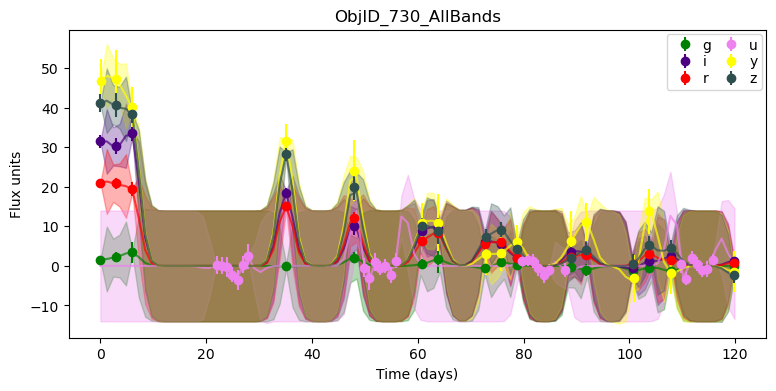

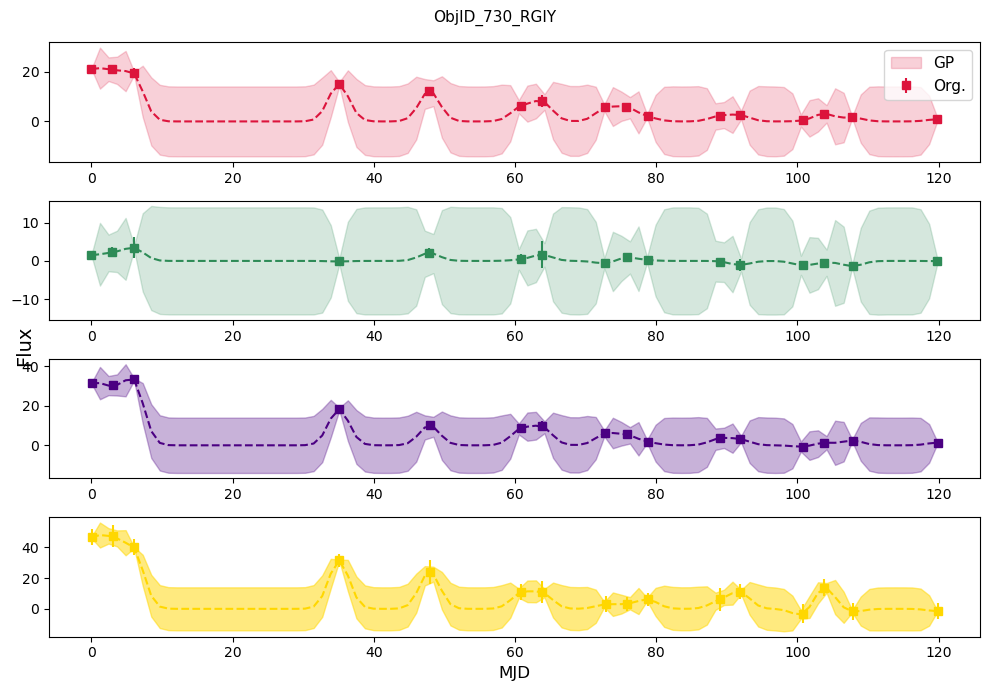

In [11]:
obj_id = object_list[2]

GP_class_init = GP_Kernels_Classes.GP_for_transient(input_df=training, obj_id=obj_id)

obs_transient = GP_class_init.shift_time()

x_dates_dict, y_dict, y_err_dict = GP_Kernels_Classes.return_flux_w_err(obs_transient)

obj_gps = GP_class_init.gp_fit_predict(kernel='RBF')
obj_gps = GP_class_init.pred_gp_fl_final(kernel='RBF')




x_dates_dict_gp, y_dict_gp, y_err_dict_gp = GP_Kernels_Classes.return_flux_w_err(obj_gps)

##################################
# final plot for original and GP
##################################
GP_Kernels_Classes.plot_real_data_and_model(obs_transient, obj_id, obj_model=obj_gps)

GP_Kernels_Classes.plot_4_bands_w_GP(x_dates_dict, x_dates_dict_gp, 
                                     y_dict, y_dict_gp, 
                                     y_err_dict, y_err_dict_gp, obj_id)